## PREDICT THE BURNED AREA OF FOREST FIRES WITH NEURAL NETWORKS

In [1]:
# pip install tensorflow

In [2]:
# pip install keras

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense,Dropout
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam,RMSprop
from sklearn.model_selection import GridSearchCV,KFold

2022-09-28 12:50:37.784332: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
fire = pd.read_csv("https://s3-ap-southeast-1.amazonaws.com/elearning.excelr.com/Assignments/Assignments/forestfires.csv")
fire

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,1,0,0,0,0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,1,0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,1,0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,1,0,0,0,0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,1,0,0,0,0,small
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,...,0,0,0,0,0,0,0,0,0,large
513,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,...,0,0,0,0,0,0,0,0,0,large
514,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,...,0,0,0,0,0,0,0,0,0,large
515,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,...,0,0,0,0,0,0,0,0,0,small


### EDA

In [5]:
fire.shape

(517, 31)

In [6]:
fire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          517 non-null    object 
 1   day            517 non-null    object 
 2   FFMC           517 non-null    float64
 3   DMC            517 non-null    float64
 4   DC             517 non-null    float64
 5   ISI            517 non-null    float64
 6   temp           517 non-null    float64
 7   RH             517 non-null    int64  
 8   wind           517 non-null    float64
 9   rain           517 non-null    float64
 10  area           517 non-null    float64
 11  dayfri         517 non-null    int64  
 12  daymon         517 non-null    int64  
 13  daysat         517 non-null    int64  
 14  daysun         517 non-null    int64  
 15  daythu         517 non-null    int64  
 16  daytue         517 non-null    int64  
 17  daywed         517 non-null    int64  
 18  monthapr  

In [7]:
fire.describe()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,...,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,...,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292,0.164410,...,0.017408,0.038685,0.003868,0.061896,0.032882,0.104449,0.003868,0.001934,0.029014,0.332689
std,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818,0.371006,...,0.130913,0.193029,0.062137,0.241199,0.178500,0.306138,0.062137,0.043980,0.168007,0.471632
min,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
fire.isnull()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
513,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
514,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
515,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [9]:
fire.isnull().sum()

month            0
day              0
FFMC             0
DMC              0
DC               0
ISI              0
temp             0
RH               0
wind             0
rain             0
area             0
dayfri           0
daymon           0
daysat           0
daysun           0
daythu           0
daytue           0
daywed           0
monthapr         0
monthaug         0
monthdec         0
monthfeb         0
monthjan         0
monthjul         0
monthjun         0
monthmar         0
monthmay         0
monthnov         0
monthoct         0
monthsep         0
size_category    0
dtype: int64

In [10]:
fire.columns

Index(['month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind',
       'rain', 'area', 'dayfri', 'daymon', 'daysat', 'daysun', 'daythu',
       'daytue', 'daywed', 'monthapr', 'monthaug', 'monthdec', 'monthfeb',
       'monthjan', 'monthjul', 'monthjun', 'monthmar', 'monthmay', 'monthnov',
       'monthoct', 'monthsep', 'size_category'],
      dtype='object')

<AxesSubplot:xlabel='size_category', ylabel='count'>

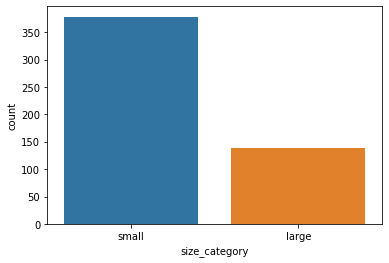

In [11]:
sns.countplot(fire['size_category'])

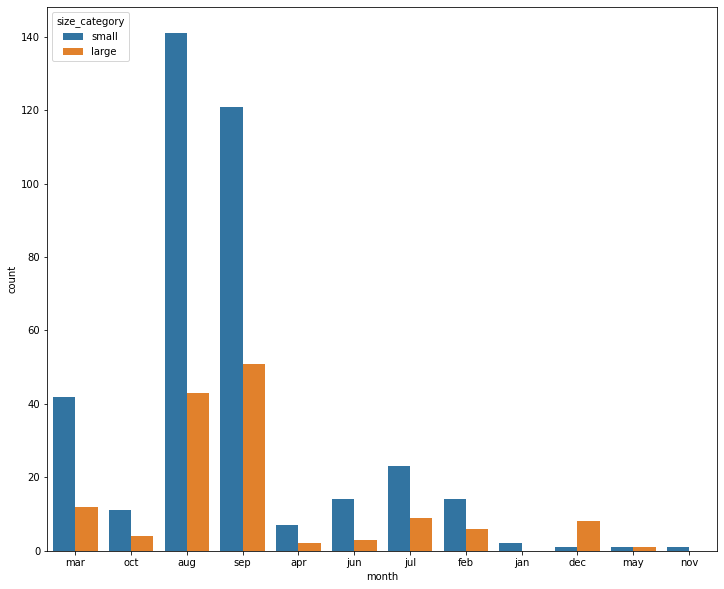

In [12]:
plt.figure(figsize=(12,10))
sns.countplot(x = fire['month'], hue = fire['size_category'])
plt.show()

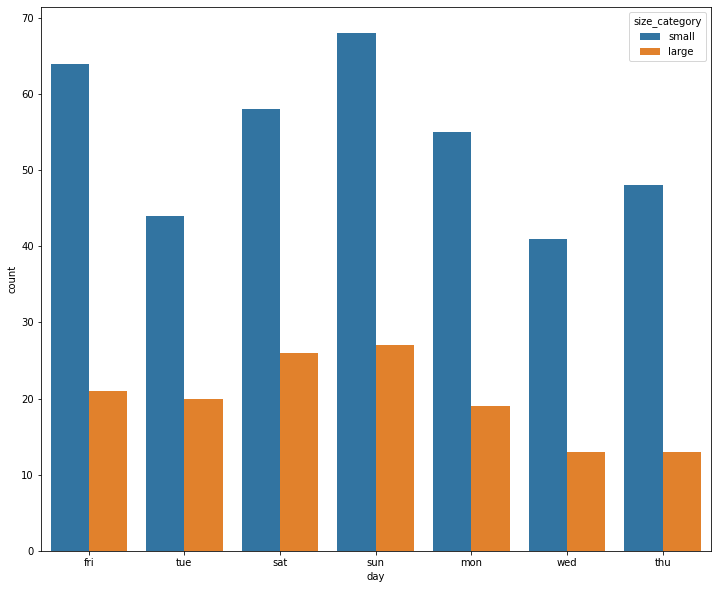

In [13]:
plt.figure(figsize=(12,10))
sns.countplot(x = fire['day'], hue = fire['size_category'])
plt.show()

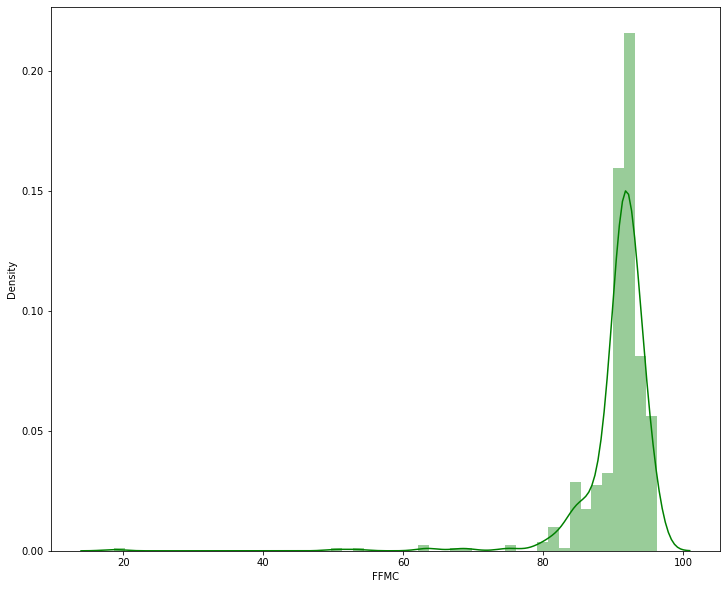

In [14]:
plt.figure(figsize = (12,10))
sns.distplot(fire['FFMC'],color='green')
plt.show()

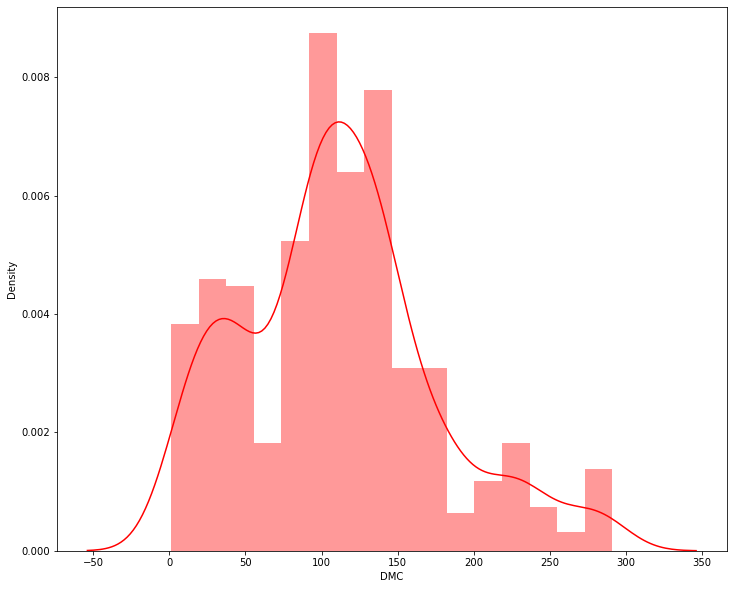

In [15]:
plt.figure(figsize = (12,10))
sns.distplot(fire['DMC'],color='red')
plt.show()

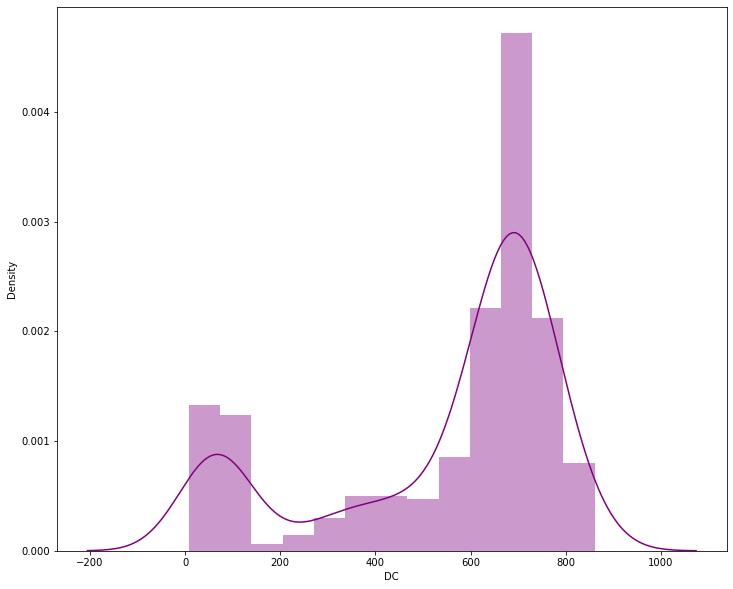

In [16]:
plt.figure(figsize = (12,10))
sns.distplot(fire['DC'],color='purple')
plt.show()

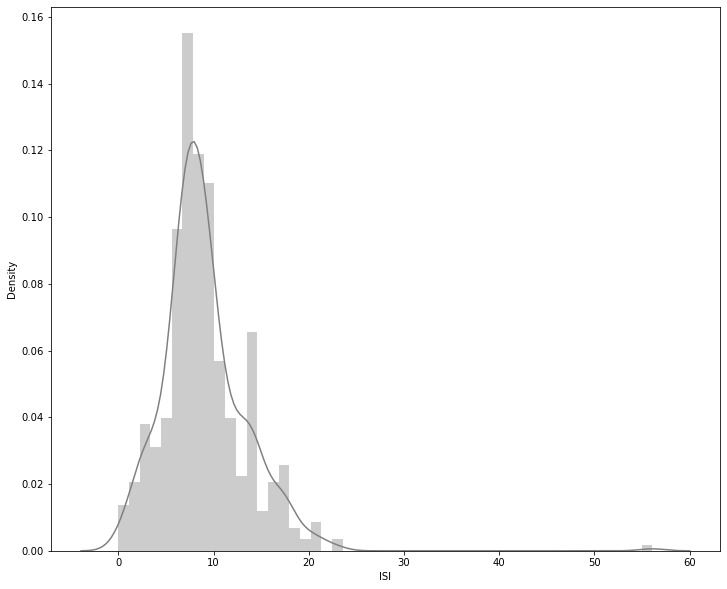

In [17]:
plt.figure(figsize = (12,10))
sns.distplot(fire['ISI'],color='grey')
plt.show()

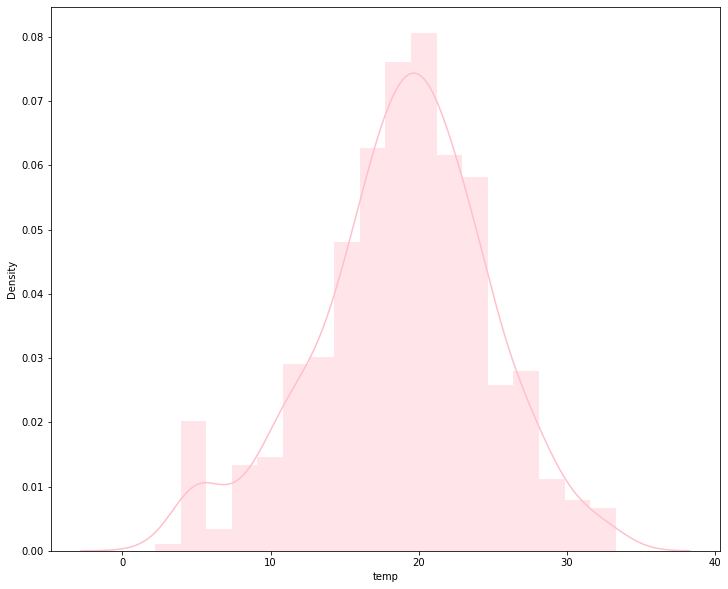

In [18]:
plt.figure(figsize = (12,10))
sns.distplot(fire['temp'],color='pink')
plt.show()

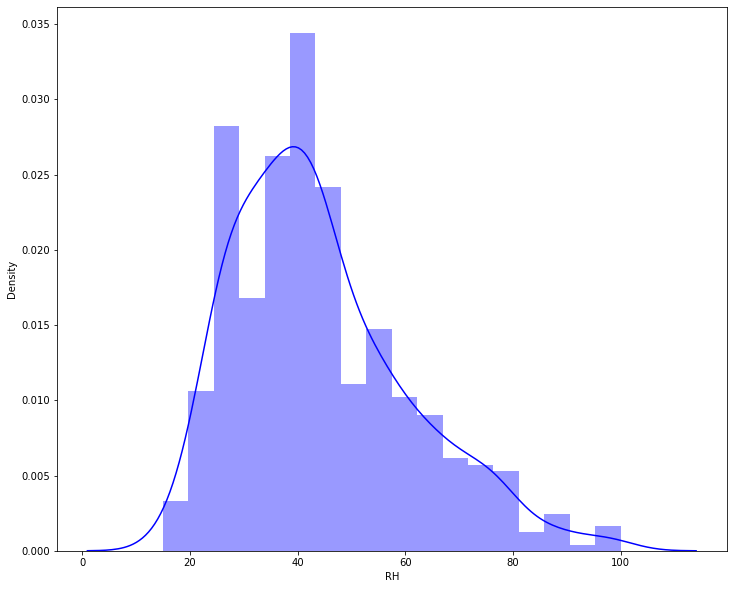

In [19]:
plt.figure(figsize = (12,10))
sns.distplot(fire['RH'],color='blue')
plt.show()

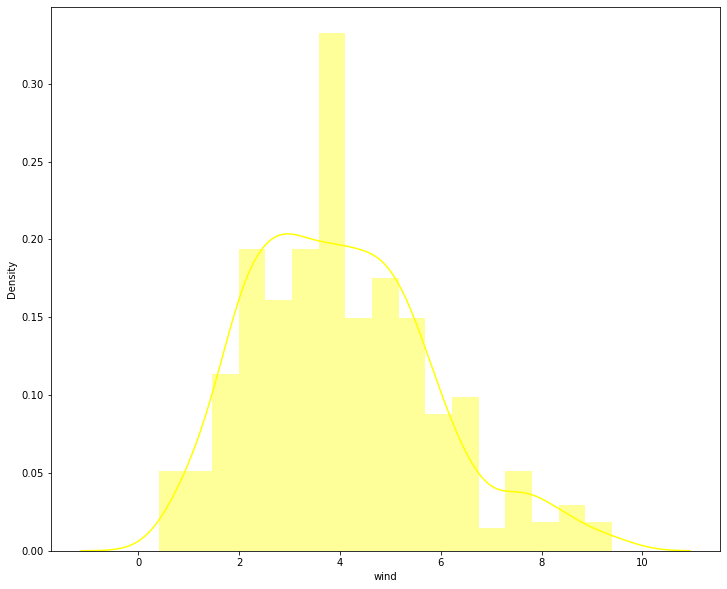

In [20]:
plt.figure(figsize = (12,10))
sns.distplot(fire['wind'],color='yellow')
plt.show()

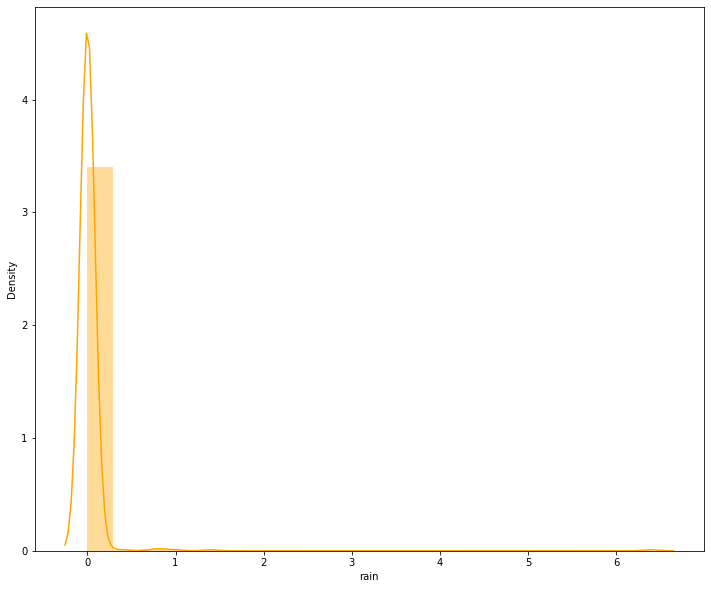

In [21]:
plt.figure(figsize = (12,10))
sns.distplot(fire['rain'],color='orange')
plt.show()

In [22]:
drop_col = fire.drop(labels = ['month', 'day'], axis = 1)
drop_col

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00,1,...,0,0,0,0,1,0,0,0,0,small
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00,0,...,0,0,0,0,0,0,0,1,0,small
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00,0,...,0,0,0,0,0,0,0,1,0,small
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00,1,...,0,0,0,0,1,0,0,0,0,small
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00,0,...,0,0,0,0,1,0,0,0,0,small
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44,0,...,0,0,0,0,0,0,0,0,0,large
513,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29,0,...,0,0,0,0,0,0,0,0,0,large
514,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16,0,...,0,0,0,0,0,0,0,0,0,large
515,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00,0,...,0,0,0,0,0,0,0,0,0,small


In [23]:
drop_col.shape

(517, 29)

In [24]:
from sklearn import preprocessing
labelEncoder = preprocessing.LabelEncoder()

In [25]:
le = labelEncoder
drop_col['size_category'] = le.fit_transform(drop_col['size_category'])
drop_col

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00,1,...,0,0,0,0,1,0,0,0,0,1
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00,0,...,0,0,0,0,0,0,0,1,0,1
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00,0,...,0,0,0,0,0,0,0,1,0,1
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00,1,...,0,0,0,0,1,0,0,0,0,1
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00,0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44,0,...,0,0,0,0,0,0,0,0,0,0
513,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29,0,...,0,0,0,0,0,0,0,0,0,0
514,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16,0,...,0,0,0,0,0,0,0,0,0,0
515,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00,0,...,0,0,0,0,0,0,0,0,0,1


<AxesSubplot:xlabel='size_category', ylabel='count'>

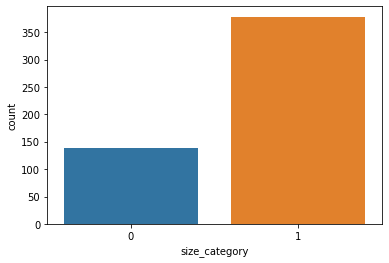

In [26]:
sns.countplot(drop_col['size_category'])

In [27]:
drop_col['size_category'].replace({'small':0,'large':0},inplace = True)
drop_col

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00,1,...,0,0,0,0,1,0,0,0,0,1
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00,0,...,0,0,0,0,0,0,0,1,0,1
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00,0,...,0,0,0,0,0,0,0,1,0,1
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00,1,...,0,0,0,0,1,0,0,0,0,1
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00,0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44,0,...,0,0,0,0,0,0,0,0,0,0
513,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29,0,...,0,0,0,0,0,0,0,0,0,0
514,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16,0,...,0,0,0,0,0,0,0,0,0,0
515,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00,0,...,0,0,0,0,0,0,0,0,0,1


In [28]:
fire_corr = drop_col.corr()
fire_corr

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
FFMC,1.000000,0.382619,0.330512,0.531805,0.431532,-0.300995,-0.028485,0.056702,0.040122,0.019306,...,-0.281535,-0.454771,0.031833,-0.040634,-0.074327,-0.037230,-0.088964,-0.005998,0.076609,-0.022063
DMC,0.382619,1.000000,0.682192,0.305128,0.469594,0.073795,-0.105342,0.074790,0.072994,-0.012010,...,-0.317899,-0.105647,-0.001946,-0.050403,-0.407404,-0.081980,-0.074218,-0.187632,0.110907,-0.034715
DC,0.330512,0.682192,1.000000,0.229154,0.496208,-0.039192,-0.203466,0.035861,0.049383,-0.004220,...,-0.399277,-0.115064,-0.100887,-0.186183,-0.650427,-0.114209,-0.078380,0.093279,0.531857,-0.019428
ISI,0.531805,0.305128,0.229154,1.000000,0.394287,-0.132517,0.106826,0.067668,0.008258,0.046695,...,-0.249777,-0.103588,0.020982,0.111516,-0.143520,-0.060493,-0.076559,-0.071154,-0.068877,0.008726
temp,0.431532,0.469594,0.496208,0.394287,1.000000,-0.527390,-0.227116,0.069491,0.097844,-0.071949,...,-0.320015,-0.146520,0.142588,0.051015,-0.341797,-0.045540,-0.053798,-0.053513,0.088006,-0.006021
RH,-0.300995,0.073795,-0.039192,-0.132517,-0.527390,1.000000,0.069410,0.099751,-0.075519,0.064506,...,0.140430,0.170923,0.013185,0.009382,-0.089836,0.086822,-0.035885,-0.072334,-0.062596,0.045243
wind,-0.028485,-0.105342,-0.203466,0.106826,-0.227116,0.069410,1.000000,0.061119,0.012317,0.118090,...,-0.029431,-0.070245,-0.040645,0.012124,0.181433,0.015054,0.011864,-0.053850,-0.181476,-0.059113
rain,0.056702,0.074790,0.035861,0.067668,0.069491,0.099751,0.061119,1.000000,-0.007366,-0.004261,...,-0.014698,-0.004566,-0.013390,-0.013510,-0.020744,-0.004566,-0.003225,-0.012665,-0.051733,-0.050001
area,0.040122,0.072994,0.049383,0.008258,0.097844,-0.075519,0.012317,-0.007366,1.000000,-0.052911,...,-0.020732,-0.012589,0.006149,-0.020314,-0.045596,0.006264,-0.008893,-0.016878,0.056573,-0.311322
dayfri,0.019306,-0.012010,-0.004220,0.046695,-0.071949,0.064506,0.118090,-0.004261,-0.052911,1.000000,...,0.046323,-0.027643,-0.048969,0.006000,0.036205,0.056423,-0.019527,-0.045585,0.107671,0.021810


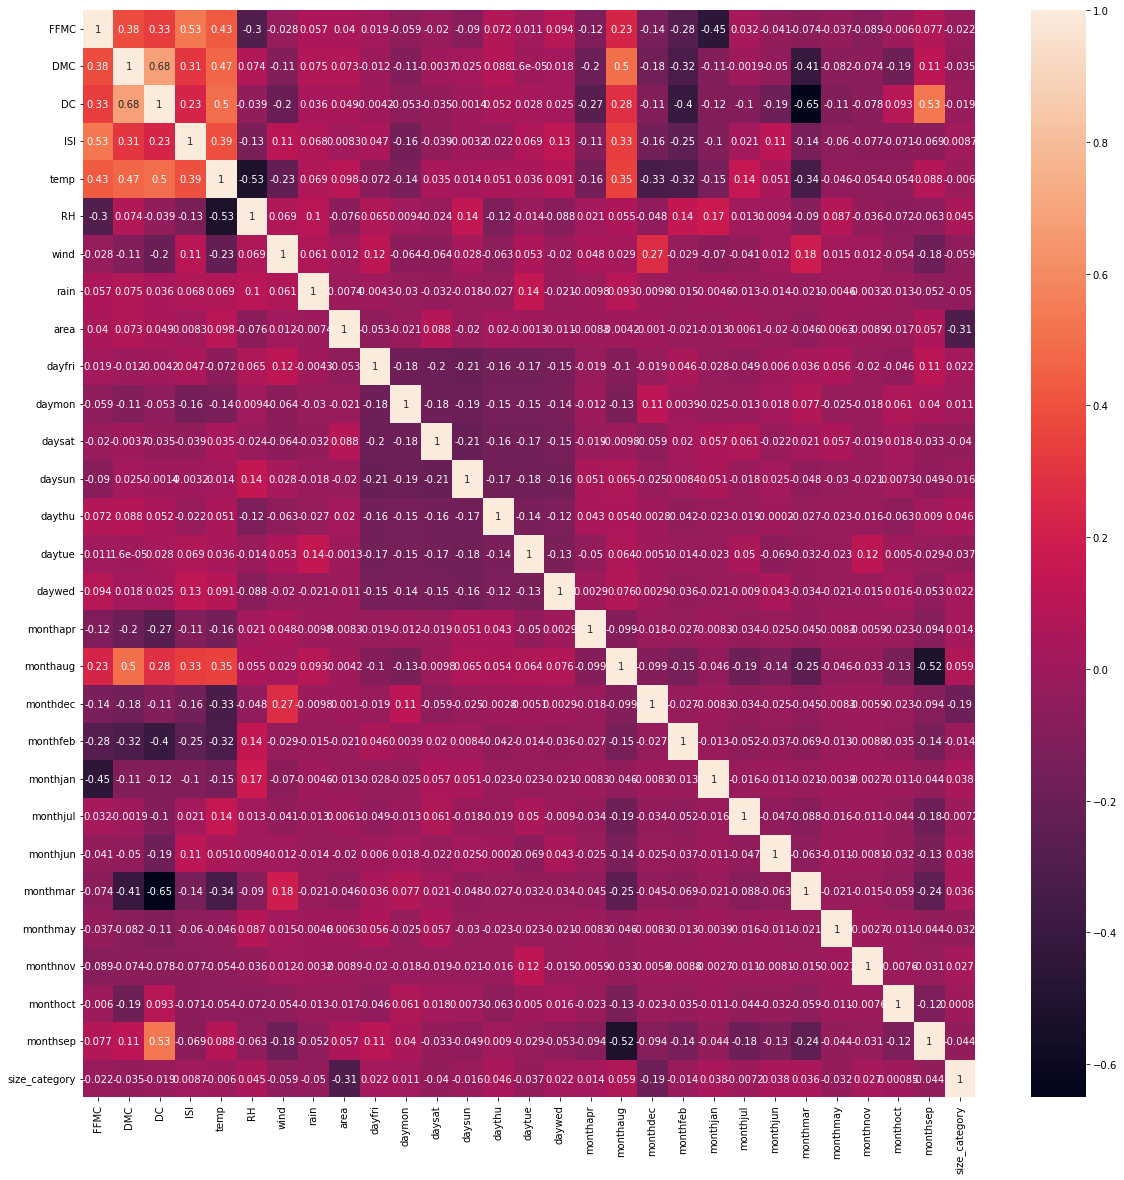

In [29]:
plt.figure(figsize = (20,20))
sns.heatmap(fire_corr, annot = True)
plt.show()

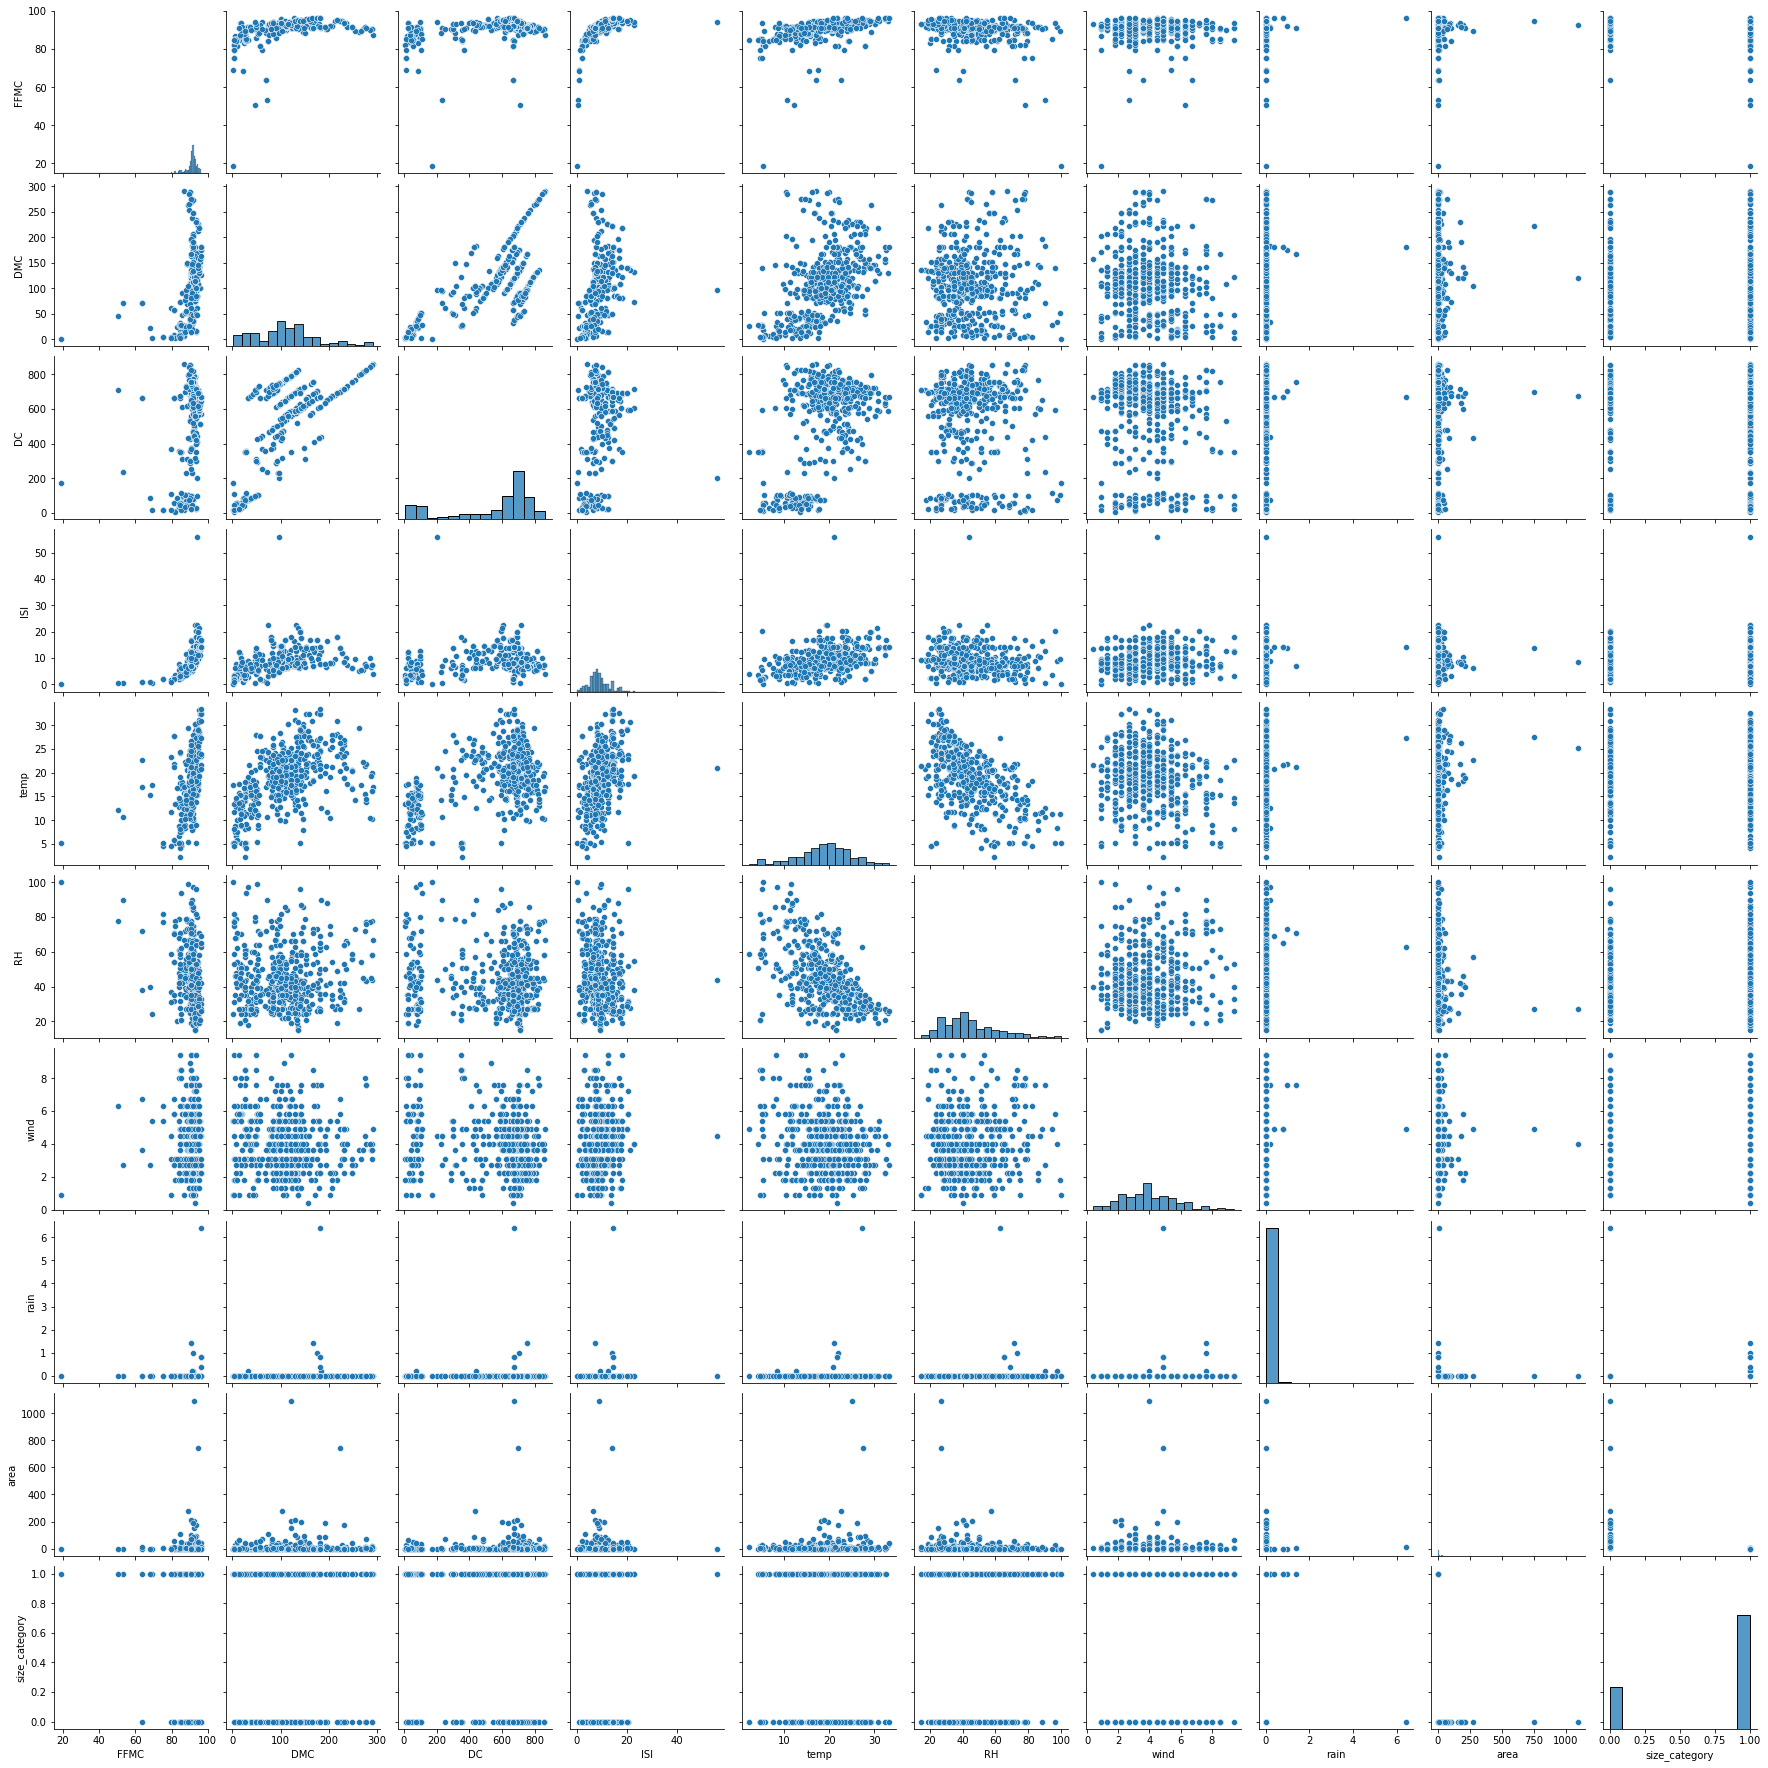

In [30]:
pair_data = pd.concat([drop_col.iloc[:,0:9], drop_col.iloc[:,-1]],axis = 1)
sns.pairplot(pair_data)
plt.show()

### Model Building

In [31]:
x = drop_col.drop(labels='size_category',axis = 1)
y = drop_col[['size_category']]

In [32]:
x

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,...,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00,1,...,0,0,0,0,0,1,0,0,0,0
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00,0,...,0,0,0,0,0,0,0,0,1,0
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00,0,...,0,0,0,0,0,0,0,0,1,0
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00,1,...,0,0,0,0,0,1,0,0,0,0
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44,0,...,0,0,0,0,0,0,0,0,0,0
513,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29,0,...,0,0,0,0,0,0,0,0,0,0
514,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16,0,...,0,0,0,0,0,0,0,0,0,0
515,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
y

,size_category
0,1
1,1
2,1
3,1
4,1
...,...
512,0
513,0
514,0
515,1


In [34]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                   test_size = .3, random_state = 45)

In [35]:
print("shape of x_train:", x_train.shape)
print("shape of y_train:", y_train.shape)

shape of x_train: (361, 28)
shape of y_train: (361, 1)


Data Is Imbalance so i have to balance it , so i m using here smote operation of balancing technique

In [36]:
sm = SMOTE(random_state=12)
x_train_sm,y_train_sm = sm.fit_resample(x_train,np.array(y_train).ravel())
x_train_sm,y_train_sm

(          FFMC         DMC          DC        ISI       temp  RH      wind  \
 0    94.300000   85.100000  692.300000  15.900000  25.900000  24  4.000000   
 1    90.900000  126.500000  686.500000   7.000000  17.700000  39  2.200000   
 2    91.200000   48.300000   97.800000  12.500000  14.600000  26  9.400000   
 3    91.000000  129.500000  692.600000   7.000000  21.600000  33  2.200000   
 4    91.700000   33.300000   77.500000   9.000000   8.300000  97  4.000000   
 ..         ...         ...         ...        ...        ...  ..       ...   
 529  91.816692  168.861892  632.588936  10.503670  20.553293  53  3.196782   
 530  85.490301   10.797771   54.557450   3.608956  10.726496  59  1.908956   
 531  91.422834  128.633841  804.064793   7.757221  13.460383  59  4.205503   
 532  92.100000   99.000000  745.300000   9.600000  20.259409  36  5.040153   
 533  64.969270   69.655431  665.324353   0.889293  23.022111  37  3.526942   
 
      rain       area  dayfri  ...  monthdec  mont

In [37]:
x_train_sm.shape, y_train_sm.shape

((534, 28), (534,))

In [38]:
x_train = x_train_sm.copy()
y_train = y_train_sm.copy()

### Converting Data into Standard Scale

In [39]:
scale = MinMaxScaler()
X_train = scale.fit_transform(x_train)
X_train

array([[0.97548387, 0.29075805, 0.80732861, ..., 0.        , 0.        ,
        1.        ],
       [0.9316129 , 0.43406023, 0.80047281, ..., 0.        , 0.        ,
        1.        ],
       [0.93548387, 0.16337833, 0.10460993, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.93835914, 0.44144632, 0.93943829, ..., 0.        , 0.        ,
        1.        ],
       [0.94709677, 0.33887158, 0.86997636, ..., 0.        , 0.        ,
        1.        ],
       [0.59702284, 0.23729813, 0.7754425 , ..., 0.        , 0.        ,
        0.        ]])

In [40]:
X_test = scale.fit_transform(x_test)
X_test

array([[0.96955504, 0.76101283, 0.81001525, ..., 0.        , 0.        ,
        0.        ],
       [0.89929742, 0.59694762, 0.81247801, ..., 0.        , 0.        ,
        0.        ],
       [0.84074941, 0.16753382, 0.11058989, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.90632319, 0.33298647, 0.86478246, ..., 0.        , 0.        ,
        1.        ],
       [0.91803279, 0.1508845 , 0.80204058, ..., 0.        , 1.        ,
        0.        ],
       [0.96955504, 0.76101283, 0.81001525, ..., 0.        , 0.        ,
        0.        ]])

### Model Training

Tuning of Hyperparameter : Batch size and Epoch

In [41]:
def creat_model():
    model = Sequential()
    model.add(Dense(8, input_dim = 28,kernel_initializer='uniform', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(4,kernel_initializer='uniform', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1,kernel_initializer='uniform', activation='sigmoid'))
    adam = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy',optimizer = adam,metrics='accuracy')
    return model

In [42]:
model = KerasClassifier(build_fn=creat_model,verbose = 0)
batch_size = [10,30,50]
epochs = [10,20,50]
param_grid = dict(batch_size = batch_size,epochs = epochs)
gsv = GridSearchCV(estimator=model,param_grid=param_grid,cv = KFold(),verbose=5)
gsv_res = gsv.fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


2022-09-28 12:50:59.026408: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV 1/5] END ..........batch_size=10, epochs=10;, score=0.720 total time=   1.0s
[CV 2/5] END ..........batch_size=10, epochs=10;, score=0.262 total time=   0.8s
[CV 3/5] END ..........batch_size=10, epochs=10;, score=0.617 total time=   0.8s
[CV 4/5] END ..........batch_size=10, epochs=10;, score=0.271 total time=   0.8s
[CV 5/5] END ..........batch_size=10, epochs=10;, score=0.000 total time=   0.8s
[CV 1/5] END ..........batch_size=10, epochs=20;, score=0.692 total time=   1.1s
[CV 2/5] END ..........batch_size=10, epochs=20;, score=0.794 total time=   1.1s
[CV 3/5] END ..........batch_size=10, epochs=20;, score=0.729 total time=   1.1s
[CV 4/5] END ..........batch_size=10, epochs=20;, score=0.682 total time=   1.5s
[CV 5/5] END ..........batch_size=10, epochs=20;, score=0.000 total time=   1.1s
[CV 1/5] END ..........batch_size=10, epochs=50;, score=0.766 total time=   2.0s
[CV 2/5] END ..........batch_size=10, epochs=50;, score=0.804 total time=   2.0s
[CV 3/5] END ..........batch

In [43]:
print(gsv_res.best_params_,gsv_res.best_score_)

{'batch_size': 10, 'epochs': 50} 0.8091165661811829


In [44]:
#Turning Hyperparameter: Learning rate and Dropout rate
def creat_model(learning_rate,dropout_rate):
    model = Sequential()
    model.add(Dense(8, input_dim = 28,kernel_initializer='uniform', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(4,kernel_initializer='uniform', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1,kernel_initializer='uniform', activation='sigmoid'))
    adam = Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy',optimizer = adam,metrics='accuracy')
    return model

In [45]:
model = KerasClassifier(build_fn=creat_model,batch_size = 10,epochs = 50,verbose = 0)
learning_rate = [0.1,0.01,0.001]
dropout_rate = [0.0,0.1,0.2]
param_grid = dict(learning_rate = learning_rate,dropout_rate = dropout_rate)
gsv = GridSearchCV(estimator=model,param_grid=param_grid,cv= KFold(),verbose=5)
gsv_r = gsv.fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END dropout_rate=0.0, learning_rate=0.1;, score=0.252 total time=   2.0s
[CV 2/5] END dropout_rate=0.0, learning_rate=0.1;, score=0.262 total time=   2.1s
[CV 3/5] END dropout_rate=0.0, learning_rate=0.1;, score=0.262 total time=   2.1s
[CV 4/5] END dropout_rate=0.0, learning_rate=0.1;, score=0.271 total time=   2.0s
[CV 5/5] END dropout_rate=0.0, learning_rate=0.1;, score=0.000 total time=   2.2s
[CV 1/5] END dropout_rate=0.0, learning_rate=0.01;, score=0.673 total time=   2.2s
[CV 2/5] END dropout_rate=0.0, learning_rate=0.01;, score=0.860 total time=   2.2s
[CV 3/5] END dropout_rate=0.0, learning_rate=0.01;, score=0.766 total time=   2.1s
[CV 4/5] END dropout_rate=0.0, learning_rate=0.01;, score=0.271 total time=   2.3s
[CV 5/5] END dropout_rate=0.0, learning_rate=0.01;, score=0.972 total time=   2.2s
[CV 1/5] END dropout_rate=0.0, learning_rate=0.001;, score=0.757 total time=   2.4s
[CV 2/5] END dropout_rate=0.0, 

In [46]:
print(gsv_r.best_params_,gsv_r.best_score_)

{'dropout_rate': 0.1, 'learning_rate': 0.001} 0.822271192073822


 Tuning of Hyperparameter :Activation Function & Kernel Initializer

In [47]:
def creat_model(Activation_Function,init):
    model = Sequential()
    model.add(Dense(8, input_dim = 28,kernel_initializer='uniform', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(4,kernel_initializer='uniform', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1,kernel_initializer='uniform', activation='sigmoid'))
    adam = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy',optimizer = adam,metrics='accuracy')
    return model

In [48]:
model = KerasClassifier(build_fn=creat_model,batch_size = 10,epochs = 50,verbose = 0)
Activation_Function = ['relu','tanh','softmax','linear']
init = ['zero','uniform','normal']
param_grid = dict(Activation_Function = Activation_Function,init = init)

gsv = GridSearchCV(estimator=model,param_grid=param_grid,cv= KFold(),verbose=5)
gsv_result = gsv.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END Activation_Function=relu, init=zero;, score=0.748 total time=   2.3s
[CV 2/5] END Activation_Function=relu, init=zero;, score=0.813 total time=   2.2s
[CV 3/5] END Activation_Function=relu, init=zero;, score=0.748 total time=   2.3s
[CV 4/5] END Activation_Function=relu, init=zero;, score=0.841 total time=   2.7s
[CV 5/5] END Activation_Function=relu, init=zero;, score=0.000 total time=   2.4s
[CV 1/5] END Activation_Function=relu, init=uniform;, score=0.748 total time=   2.5s
[CV 2/5] END Activation_Function=relu, init=uniform;, score=0.832 total time=   2.4s
[CV 3/5] END Activation_Function=relu, init=uniform;, score=0.776 total time=   3.0s
[CV 4/5] END Activation_Function=relu, init=uniform;, score=0.841 total time=   2.6s
[CV 5/5] END Activation_Function=relu, init=uniform;, score=0.877 total time=   2.8s
[CV 1/5] END Activation_Function=relu, init=normal;, score=0.757 total time=   2.8s
[CV 2/5] END Activat

In [49]:
print(gsv_result.best_score_,gsv_result.best_params_)

0.8297831058502197 {'Activation_Function': 'linear', 'init': 'uniform'}


Tuning of Hyperparameter :Number of Neurons in hidden layer

In [50]:
def creat_model(neuron1,neuron2):
    model = Sequential()
    model.add(Dense(8,input_dim=28,kernel_initializer='normal', activation='tanh'))
    model.add(Dropout(0.1))
    model.add(Dense(4,kernel_initializer='normal',activation='tanh'))
    model.add(Dropout(0.1))
    model.add(Dense(1,kernel_initializer='normal',activation='sigmoid'))
    adam = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

In [51]:
model = KerasClassifier(build_fn=creat_model,batch_size = 10,epochs = 50,verbose = 0)
neuron1 = [24,16,8]
neuron2 = [12,8,4]
param_grid = dict(neuron1 = neuron1,neuron2=neuron2)
gsv = GridSearchCV(estimator=model,param_grid=param_grid,cv=KFold(),verbose=5)
gsv_n = gsv.fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ............neuron1=24, neuron2=12;, score=0.804 total time=   2.4s
[CV 2/5] END ............neuron1=24, neuron2=12;, score=0.850 total time=   2.5s
[CV 3/5] END ............neuron1=24, neuron2=12;, score=0.804 total time=   2.5s
[CV 4/5] END ............neuron1=24, neuron2=12;, score=0.860 total time=   2.7s
[CV 5/5] END ............neuron1=24, neuron2=12;, score=0.925 total time=   2.6s
[CV 1/5] END .............neuron1=24, neuron2=8;, score=0.813 total time=   2.5s
[CV 2/5] END .............neuron1=24, neuron2=8;, score=0.841 total time=   2.9s
[CV 3/5] END .............neuron1=24, neuron2=8;, score=0.813 total time=   2.7s
[CV 4/5] END .............neuron1=24, neuron2=8;, score=0.869 total time=   2.7s
[CV 5/5] END .............neuron1=24, neuron2=8;, score=0.915 total time=   2.7s
[CV 1/5] END .............neuron1=24, neuron2=4;, score=0.813 total time=   2.7s
[CV 2/5] END .............neuron1=24, neuron2=4;,

In [52]:
print(gsv_n.best_score_,gsv_n.best_params_)

0.854082179069519 {'neuron1': 24, 'neuron2': 4}


Train a model with optimum values of hyperparameter

In [53]:
# best Parameters
# batch_size = 10
# epochs = 50
# dropout_rate = 0.1
# learning rate = 0.001
# activation_function = tanh
# kernel_initiative = normal
# neuron1 = 8
# neuron2 = 8

In [54]:
def creat_model():
    model = Sequential()
    model.add(Dense(8,input_dim=28,kernel_initializer='normal', activation='tanh'))
    model.add(Dropout(0.1))
    model.add(Dense(8,kernel_initializer='normal',activation='tanh'))
    model.add(Dropout(0.1))
    model.add(Dense(1,kernel_initializer='normal',activation='sigmoid'))
    adam = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

In [55]:
model = KerasClassifier(build_fn=creat_model,batch_size = 10,epochs = 50)
model.fit(X_train,y_train)

Epoch 1/50
54/54 [==============================] - 1s 2ms/step - loss: 0.6933 - accuracy: 0.4738
Epoch 2/50
54/54 [==============================] - 0s 2ms/step - loss: 0.6924 - accuracy: 0.5655
Epoch 3/50
54/54 [==============================] - 0s 1ms/step - loss: 0.6894 - accuracy: 0.5637
Epoch 4/50
54/54 [==============================] - 0s 1ms/step - loss: 0.6720 - accuracy: 0.7303
Epoch 5/50
54/54 [==============================] - 0s 1ms/step - loss: 0.6199 - accuracy: 0.7640
Epoch 6/50
54/54 [==============================] - 0s 1ms/step - loss: 0.5488 - accuracy: 0.7978
Epoch 7/50
54/54 [==============================] - 0s 1ms/step - loss: 0.4932 - accuracy: 0.7978
Epoch 8/50
54/54 [==============================] - 0s 1ms/step - loss: 0.4515 - accuracy: 0.7996
Epoch 9/50
54/54 [==============================] - 0s 1ms/step - loss: 0.4277 - accuracy: 0.8127
Epoch 10/50
54/54 [==============================] - 0s 1ms/step - loss: 0.4029 - accuracy: 0.8165
Epoch 11/50
54/54 [

In [56]:
y_predict = model.predict(X_train)

17/17 [==============================] - 0s 856us/step


In [57]:
accuracy_score(y_train,y_predict)

0.9400749063670412

In [58]:
confusion_matrix(y_train,y_predict)

array([[245,  22],
       [ 10, 257]])

In [59]:
print(classification_report(y_train,y_predict))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       267
           1       0.92      0.96      0.94       267

    accuracy                           0.94       534
   macro avg       0.94      0.94      0.94       534
weighted avg       0.94      0.94      0.94       534



In [60]:
# testing data
y_test_pred = model.predict(X_test)

5/5 [==============================] - 0s 1ms/step


In [61]:
accuracy_score(y_test,y_test_pred)

0.9038461538461539

In [62]:
confusion_matrix(y_test,y_test_pred)

array([[45,  0],
       [15, 96]])

In [63]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86        45
           1       1.00      0.86      0.93       111

    accuracy                           0.90       156
   macro avg       0.88      0.93      0.89       156
weighted avg       0.93      0.90      0.91       156

